In [ ]:
!pip install segysak
!pip install segyio
! pip install -q torchview
!pip install torchviz
!pip install graphviz

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [3]:
import time
import segyio
import pathlib
import warnings
import numpy as np
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore", category=UserWarning)

import torch
from torch import nn
import torch.optim as  optim
from torch.nn  import functional as F
from torch.utils.data import DataLoader, Dataset

from IPython.display import display
from segysak.segy import segy_loader, well_known_byte_locs, segy_writer, get_segy_texthead

In [4]:
path = "/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/seismic.segy"
path1 = "/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/TrainingData_Image.segy"
path2 = "/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/TestData_Image1.segy"

In [5]:
# def NormalizeData(data):
#     return np.pad((data - np.min(data)) / (np.max(data) - np.min(data)), (9, 9), 'edge')

# xx = NormalizeData(our_data[0])
# plt.figure()
# plt.plot(np.arange(len(xx)), xx)
# plt.show()

In [6]:
def load_training_field(path):
    import segyio  # used to load seismic data
    import numpy as np
    import matplotlib.pyplot as plt
    with segyio.open(path) as f:
    # if the above does NOT work, try the below line
    # with segyio.open(path, ignore_geometry=True) as f:
        # for trace in f.trace:
        #     filtered = trace[np.where(trace < 1e-2)] #I don't know what this does
        data = segyio.tools.cube(f)    #data[ilines,xlines,traces]
        data = np.moveaxis(data, 1, 2) #data[ilines,traces,xlines]
        # In the above, I have switched the order of the axis. Originally, the
        # image looked a bit "off" to me, so I "felt" that ordering the axis this
        # way makes more sense to me, but I can be wrong, so play around with it.
        # It could depend on the data that you are using.
        # No particular reason for including the below lines. Though, having them
        # won't hurt, so I will leave them here. Return them if you need them
        # offsets = f.offsets
        # xlines = f.xlines
        # ilines = f.ilines
    #Plotting the results
    # plt.figure(figsize=(5.5,5.5)) #dpi=300, 
    # plt.axis('off')
    # plt.title("2D Slice of a 3D Seismic Image")
    # plt.imshow(data[0], cmap='gray_r') #you can change the cmap to 'seismic_r'
    # plt.colorbar()
    # print(data[0].shape)
    return data

In [7]:
def get_min_max(data):
    max_data = np.max(data)
    min_data = np.min(data)
    return max_data, min_data

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
max_1, min_1 = get_min_max(load_training_field(path1))
print(max_1, min_1)

5151.7188 -5195.5234


5247.8906 -4723.0117
(251, 1006, 782)


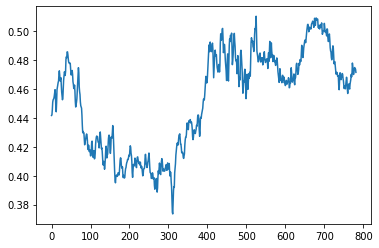

In [8]:
max_2, min_2 = get_min_max(load_training_field(path2))
print(max_2, min_2)
hey = NormalizeData(load_training_field(path2))
print(hey.shape)
hey_validation = hey[0:20]
hey_test = hey[230:]
plt.plot(np.arange(len(hey[0][0])), hey[0][0])

In [9]:
def NormalizeData1(path_):
    our_data = torch.from_numpy(load_training_field(path_))
    a, b, c = our_data.shape
    our_data = torch.reshape(our_data, (a*b, 1, c))
    # m = nn.ReplicationPad2d(9)
    temp = (our_data - torch.min(our_data)) / (torch.max(our_data) - torch.min(our_data))
    return temp

In [ ]:
our_data = NormalizeData1(path1)
our_data = torch.reshape(our_data, (590, 1006, 782))
our_data.shape

torch.Size([590, 1006, 782])

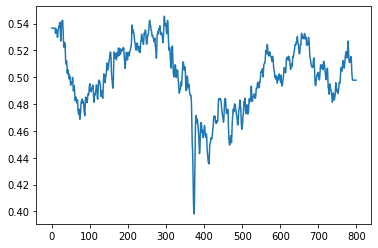

In [ ]:
tt = F.pad(our_data[0], (9, 9), "replicate")
tt = tt.cpu().detach().numpy()
tt = list(tt[0])
plt.plot(np.arange(len(tt)), tt)

In [10]:
class MyDataset(Dataset):
    
    # load the dataset
    def __init__(self, data_path, pad = True):
        
        # store the inputs and outputs
        self.our_data = NormalizeData1(data_path)
        self.pad = pad
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.our_data)
 
    # get a row at an index
    def __getitem__(self, index):
        if self.pad:
            xx = F.pad(self.our_data[index], (9, 9), "replicate")
            yy = F.pad(self.our_data[index], (9, 9), "replicate")
        else:  
            xx = self.our_data[index]
            yy = self.our_data[index]
        return xx, yy

def NormalizeData2(data):
    our_data = torch.from_numpy(data)
    a, b, c = our_data.shape
    our_data = torch.reshape(our_data, (a*b, 1, c))
    # m = nn.ReplicationPad2d(9)
    temp = (our_data - torch.min(our_data)) / (torch.max(our_data) - torch.min(our_data))
    return temp

class ValidationDataset(Dataset):
    
    # load the dataset
    def __init__(self, data, pad = True):
        
        # store the inputs and outputs
        self.our_data = NormalizeData2(data)
        self.pad = pad
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.our_data)
 
    # get a row at an index
    def __getitem__(self, index):
        if self.pad:
            xx = F.pad(self.our_data[index], (9, 9), "replicate")
            yy = F.pad(self.our_data[index], (9, 9), "replicate")
        else:
            xx = self.our_data[index]
            yy = self.our_data[index]
        return xx, yy

In [11]:
cuda = torch.cuda.is_available()
num_workers = 4 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 4


In [12]:
train_data = MyDataset(path1)
train_args = dict(shuffle = True, batch_size = 512, 
                  num_workers = num_workers, pin_memory = True, drop_last=True) if cuda else dict(shuffle = True, batch_size = 512)
train_loader = DataLoader(train_data, **train_args)

# Validation dataloader
val_data = ValidationDataset(hey_validation)
val_args = dict(shuffle = False, batch_size = 256, 
                num_workers = num_workers, pin_memory = True) if cuda else dict(shuffle = False, batch_size = 1)
val_loader = DataLoader(val_data, **val_args)

In [13]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 16, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.AvgPool1d(2, stride=2)
        # conv layer (depth from 16 --> 32), 1x1 kernels
        self.conv2 = nn.Conv1d(16, 32, 1)
        # conv layer (depth from 32 --> 64), 1x1 kernels
        self.conv3 = nn.Conv1d(32, 64, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool2 = nn.MaxPool1d(5, stride=5)
        # conv layer (depth from 64 --> 128), 1x1 kernels
        self.conv4 = nn.Conv1d(64, 128, 1)
        # conv layer (depth from 128 --> 1), 1x1 kernels
        self.conv5 = nn.Conv1d(128, 1, 1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        # add second hidden layer
        x = F.elu(self.conv2(x))
        # add third hidden layer
        # and maxpooling poling after
        x = F.elu(self.conv3(x))
        x = self.pool2(x)
        # add forth hidden layer
        x = F.elu(self.conv4(x))
        # add fifth hidden layer
        x = F.elu(self.conv5(x)) # compressed representation

        ## decode ##
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv5(x))

        return x

# initialize the NN

In [14]:
# define the NN architecture
class ConvAutoencoder3(nn.Module):
    def __init__(self):
        super(ConvAutoencoder3, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 16, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.AvgPool1d(2, stride=2)
        self.norm1 = nn.BatchNorm1d(16)
        # conv layer (depth from 16 --> 32), 1x1 kernels
        self.conv2 = nn.Conv1d(16, 32, 1)
        # conv layer (depth from 32 --> 64), 1x1 kernels
        self.conv3 = nn.Conv1d(32, 64, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool2 = nn.MaxPool1d(5, stride=5)
        self.norm2 = nn.BatchNorm1d(64)
        # conv layer (depth from 64 --> 128), 1x1 kernels
        self.conv4 = nn.Conv1d(64, 128, 1)
        # conv layer (depth from 128 --> 1), 1x1 kernels
        self.conv5 = nn.Conv1d(128, 1, 1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)
        # add second hidden layer
        x = F.elu(self.conv2(x))
        # add third hidden layer
        # and maxpooling poling after
        x = F.elu(self.conv3(x))
        x = self.pool2(x)
        x = self.norm2(x)
        # add forth hidden layer
        x = F.elu(self.conv4(x))
        # add fifth hidden layer
        x = F.elu(self.conv5(x)) # compressed representation

        ## decode ##
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv5(x))

        return x

# initialize the NN

In [15]:
# define the NN architecture
class ConvAutoencoder1(nn.Module):
    def __init__(self):
        super(ConvAutoencoder1, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 16, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.AvgPool1d(2, stride=2)
        # conv layer (depth from 16 --> 32), 1x1 kernels
        self.conv2 = nn.Conv1d(16, 32, 1)
        # conv layer (depth from 32 --> 64), 1x1 kernels
        self.conv3 = nn.Conv1d(32, 64, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool2 = nn.MaxPool1d(5, stride=5)
        # conv layer (depth from 64 --> 128), 1x1 kernels
        self.conv4 = nn.Conv1d(64, 128, 1)
        # conv layer (depth from 128 --> 1), 1x1 kernels
        self.conv5 = nn.Conv1d(128, 1, 1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        # add third hidden layer
        # and maxpooling poling after
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        # add forth hidden layer
        x = F.relu(self.conv4(x))
        # add fifth hidden layer
        x = F.relu(self.conv5(x)) # compressed representation

        ## decode ##
        # add transpose conv layers, with elu activation function
        x = F.relu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        x = F.relu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        x = F.relu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        x = F.relu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv5(x))

        return x

# initialize the NN

In [16]:
# define the NN architecture
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 16, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool1 = nn.AvgPool1d(2, stride=2)
        # conv layer (depth from 16 --> 32), 1x1 kernels
        self.conv2 = nn.Conv1d(16, 32, 1)
        # conv layer (depth from 32 --> 64), 1x1 kernels
        self.conv3 = nn.Conv1d(32, 64, 1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool2 = nn.MaxPool1d(5, stride=5)
        # conv layer (depth from 64 --> 128), 1x1 kernels
        self.conv4 = nn.Conv1d(64, 128, 1)
        # conv layer (depth from 128 --> 1), 1x1 kernels
        self.conv5 = nn.Conv1d(128, 1, 1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 1)
        self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 1)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        # add second hidden layer
        x = F.elu(self.conv2(x))
        # add third hidden layer
        # and maxpooling poling after
        x = F.elu(self.conv3(x))
        x = self.pool2(x)
        # add forth hidden layer
        x = F.elu(self.conv4(x))
        # add fifth hidden layer
        x = F.elu(self.conv5(x)) # compressed representation

        ## decode ##
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv1(x))
        x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv3(x))
        x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv5(x))

        return x

# initialize the NN

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(ResidualBlock, self).__init__()
        self.expansion = 1
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels * self.expansion)
        self.elu = F.elu
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.elu(x)
        return x

class TransResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_upsample=None, kernel_size = 1, stride=1):
        super(TransResidualBlock, self).__init__()
        self.expansion = 1
        self.conv1 = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.ConvTranspose1d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels * self.expansion)
        self.elu = F.elu
        self.identity_upsample = identity_upsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_upsample is not None:
            identity = self.identity_upsample(identity)

        x += identity
        x = self.elu(x)
        return x

In [18]:
# define the NN architecture
class ConvAutoencoder4(nn.Module):
    def __init__(self, encode_res_block, decode_res_block):
        super(ConvAutoencoder4, self).__init__()
        self.expansion = 1
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        # self.conv1 = nn.Conv1d(1, 8, 3, padding = 10)
        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.conv2 = nn.Conv1d(1, 1, 1)
        self.pool3 = nn.MaxPool1d(10, stride=10)
        self.norm1 = nn.BatchNorm1d(1)

        self.pool2 = nn.AvgPool1d(5, stride=5)

        self.conv5 = nn.Conv1d(128, 1, 1)
        self.in_channels = 1
        self.d_channels = 1

        layers = [2, 2, 2, 2]

        self.layer1 = self.make_layers(encode_res_block, layers[0], intermediate_channels=16, stride=1)
        self.layer2 = self.make_layers(encode_res_block, layers[1], intermediate_channels=32, stride=1)
        self.layer3 = self.make_layers(encode_res_block, layers[2], intermediate_channels=64, stride=1)
        self.layer4 = self.make_layers(encode_res_block, layers[3], intermediate_channels=128, stride=1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)

        up_layers = [1, 1, 1, 1]

        # self.up_layer1 = self.make_trans_layers(decode_res_block, up_layers[0], intermediate_channels=128, stride=5, kernel_size = 5)
        # self.up_layer2 = self.make_trans_layers(decode_res_block, up_layers[1], intermediate_channels=64, stride=1, kernel_size = 1)
        # self.up_layer3 = self.make_trans_layers(decode_res_block, up_layers[2], intermediate_channels=32, stride=1, kernel_size = 1)
        # self.up_layer4 = self.make_trans_layers(decode_res_block, up_layers[3], intermediate_channels=16, stride=2, kernel_size = 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        # x = F.elu(self.conv1(x))
        temp_x = F.elu(self.conv2(x))
        temp_x = self.pool3(temp_x)
        temp_x = self.norm1(temp_x)

        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = self.layer4(x)
        x = F.elu(self.conv5(x)) # compressed representation
        x = x + temp_x

        ## decode ##
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)

        # x = self.up_layer1(x)
        # x = self.up_layer2(x)
        # x = self.up_layer3(x)
        # x = self.up_layer4(x)
        x = torch.sigmoid(self.t_conv5(x))

        return x
    
    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def make_trans_layers(self, block, num_residual_blocks, intermediate_channels, stride=1, kernel_size = 1):
        layers = []
        # nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        identity_upsample = nn.Sequential(nn.ConvTranspose1d(self.d_channels, intermediate_channels*self.expansion, kernel_size=kernel_size, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.d_channels, intermediate_channels, identity_upsample, kernel_size=kernel_size, stride=stride))
        self.d_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.d_channels, intermediate_channels, kernel_size=1, stride=1))
        return nn.Sequential(*layers)

# initialize the NN

In [19]:
# define the NN architecture
class ConvAutoencoder5(nn.Module):
    def __init__(self, encode_res_block, decode_res_block):
        super(ConvAutoencoder5, self).__init__()
        self.expansion = 1
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 8, 3, padding = 10)
        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.conv2 = nn.Conv1d(1, 1, 1)
        self.norm1 = nn.BatchNorm1d(1)
        self.pool3 = nn.MaxPool1d(10, stride=10)

        self.pool2 = nn.AvgPool1d(5, stride=5)

        self.conv5 = nn.Conv1d(128, 1, 1)
        self.in_channels = 1
        self.d_channels = 1

        layers = [2, 2, 2, 2]

        self.layer1 = self.make_layers(encode_res_block, layers[0], intermediate_channels=16, stride=1)
        self.layer2 = self.make_layers(encode_res_block, layers[1], intermediate_channels=32, stride=1)
        self.layer3 = self.make_layers(encode_res_block, layers[2], intermediate_channels=64, stride=1)
        self.layer4 = self.make_layers(encode_res_block, layers[3], intermediate_channels=128, stride=1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)

        up_layers = [1, 1, 1, 1]

        self.up_layer1 = self.make_trans_layers(decode_res_block, up_layers[0], intermediate_channels=128, stride=5, kernel_size = 5)
        self.up_layer2 = self.make_trans_layers(decode_res_block, up_layers[1], intermediate_channels=64, stride=1, kernel_size = 1)
        self.up_layer3 = self.make_trans_layers(decode_res_block, up_layers[2], intermediate_channels=32, stride=1, kernel_size = 1)
        self.up_layer4 = self.make_trans_layers(decode_res_block, up_layers[3], intermediate_channels=16, stride=2, kernel_size = 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        # x = F.elu(self.conv1(x))
        temp_x = F.elu(self.conv2(x))
        temp_x = self.pool3(temp_x)
        temp_x = self.norm1(temp_x)

        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = self.layer4(x)
        x = F.elu(self.conv5(x)) # compressed representation
        # x = x + temp_x

        ## decode ##
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)

        x = self.up_layer1(x)
        x = self.up_layer2(x)
        x = self.up_layer3(x)
        x = self.up_layer4(x)
        x = torch.sigmoid(self.t_conv5(x))

        return x
    
    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def make_trans_layers(self, block, num_residual_blocks, intermediate_channels, stride=1, kernel_size = 1):
        layers = []
        # nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        identity_upsample = nn.Sequential(nn.ConvTranspose1d(self.d_channels, intermediate_channels*self.expansion, kernel_size=kernel_size, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.d_channels, intermediate_channels, identity_upsample, kernel_size=kernel_size, stride=stride))
        self.d_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.d_channels, intermediate_channels, kernel_size=1, stride=1))
        return nn.Sequential(*layers)

# initialize the NN

In [20]:
# define the NN architecture
class ConvAutoencoder6(nn.Module):
    def __init__(self, encode_res_block, decode_res_block):
        super(ConvAutoencoder6, self).__init__()
        self.expansion = 1
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 8, 3, padding = 10)
        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.conv2 = nn.Conv1d(1, 1, 1)
        self.norm1 = nn.BatchNorm1d(1)
        self.pool3 = nn.MaxPool1d(10, stride=10)

        self.pool2 = nn.AvgPool1d(5, stride=5)

        self.conv5 = nn.Conv1d(128, 1, 1)
        self.in_channels = 1
        self.d_channels = 1

        layers = [2, 2, 2, 2]

        self.layer1 = self.make_layers(encode_res_block, layers[0], intermediate_channels=16, stride=1)
        self.layer2 = self.make_layers(encode_res_block, layers[1], intermediate_channels=32, stride=1)
        self.layer3 = self.make_layers(encode_res_block, layers[2], intermediate_channels=64, stride=1)
        self.layer4 = self.make_layers(encode_res_block, layers[3], intermediate_channels=128, stride=1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)

        up_layers = [1, 1, 1, 1]

        self.up_layer1 = self.make_trans_layers(decode_res_block, up_layers[0], intermediate_channels=128, stride=5, kernel_size = 5)
        self.up_layer2 = self.make_trans_layers(decode_res_block, up_layers[1], intermediate_channels=64, stride=1, kernel_size = 1)
        self.up_layer3 = self.make_trans_layers(decode_res_block, up_layers[2], intermediate_channels=32, stride=1, kernel_size = 1)
        self.up_layer4 = self.make_trans_layers(decode_res_block, up_layers[3], intermediate_channels=16, stride=2, kernel_size = 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        # x = F.elu(self.conv1(x))
        temp_x = F.elu(self.conv2(x))
        temp_x = self.pool3(temp_x)
        temp_x = self.norm1(temp_x)

        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = self.layer4(x)
        x = F.elu(self.conv5(x)) # compressed representation
        x = x + temp_x

        ## decode ##
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)

        x = self.up_layer1(x)
        x = self.up_layer2(x)
        x = self.up_layer3(x)
        x = self.up_layer4(x)
        x = torch.sigmoid(self.t_conv5(x))

        return x
    
    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def make_trans_layers(self, block, num_residual_blocks, intermediate_channels, stride=1, kernel_size = 1):
        layers = []
        # nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        identity_upsample = nn.Sequential(nn.ConvTranspose1d(self.d_channels, intermediate_channels*self.expansion, kernel_size=kernel_size, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.d_channels, intermediate_channels, identity_upsample, kernel_size=kernel_size, stride=stride))
        self.d_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.d_channels, intermediate_channels, kernel_size=1, stride=1))
        return nn.Sequential(*layers)

# initialize the NN

In [21]:
# define the NN architecture
class ConvAutoencoder7(nn.Module):
    def __init__(self, encode_res_block, decode_res_block):
        super(ConvAutoencoder7, self).__init__()
        self.expansion = 1
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 1x1 kernels
        self.conv1 = nn.Conv1d(1, 8, 3, padding = 10)
        self.pool1 = nn.MaxPool1d(2, stride=2)

        self.conv2 = nn.Conv1d(1, 1, 1)
        self.norm1 = nn.BatchNorm1d(1)
        self.pool3 = nn.MaxPool1d(10, stride=10)

        self.pool2 = nn.AvgPool1d(5, stride=5)

        self.conv5 = nn.Conv1d(128, 1, 1)
        self.in_channels = 1
        self.d_channels = 1

        layers = [2, 2, 2, 2]

        self.layer1 = self.make_layers(encode_res_block, layers[0], intermediate_channels=16, stride=1)
        self.layer2 = self.make_layers(encode_res_block, layers[1], intermediate_channels=32, stride=1)
        self.layer3 = self.make_layers(encode_res_block, layers[2], intermediate_channels=64, stride=1)
        self.layer4 = self.make_layers(encode_res_block, layers[3], intermediate_channels=128, stride=1)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # we made a change here, changing upsampling to convolution transpose
        self.t_conv1 = nn.ConvTranspose1d(1, 128, 5, stride=5)
        # self.upsample1 = nn.Upsample(scale_factor=5, mode='linear')
        self.t_conv2 = nn.ConvTranspose1d(128, 64, 1)
        self.t_conv3 = nn.ConvTranspose1d(64, 32, 1)
        # self.upsample2 = nn.Upsample(scale_factor=2, mode='linear')
        self.t_conv4 = nn.ConvTranspose1d(32, 16, 2, stride=2)
        self.t_conv5 = nn.ConvTranspose1d(16, 1, 1)

        up_layers = [2, 2, 2, 2]

        self.up_layer1 = self.make_trans_layers(decode_res_block, up_layers[0], intermediate_channels=128, stride=5, kernel_size = 5)
        self.up_layer2 = self.make_trans_layers(decode_res_block, up_layers[1], intermediate_channels=64, stride=1, kernel_size = 1)
        self.up_layer3 = self.make_trans_layers(decode_res_block, up_layers[2], intermediate_channels=32, stride=1, kernel_size = 1)
        self.up_layer4 = self.make_trans_layers(decode_res_block, up_layers[3], intermediate_channels=16, stride=2, kernel_size = 2)

        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(160, 80)


    def forward(self, x):
        ## encode ##
        # add hidden layers with elu activation function
        # and average poling after
        # x = F.elu(self.conv1(x))
        temp_x = F.elu(self.conv2(x))
        temp_x = self.pool3(temp_x)
        temp_x = self.norm1(temp_x)

        x = self.layer1(x)
        x = self.pool1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool2(x)
        x = self.layer4(x)
        x = F.elu(self.conv5(x)) # compressed representation
        x = torch.cat((x, temp_x), 2)
        x = self.dropout(x)
        x = F.elu(self.linear(x))

        ## decode ##
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv1(x))
        # x = self.upsample1(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv2(x))
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv3(x))
        # x = self.upsample2(x)
        # add transpose conv layers, with elu activation function
        # x = F.elu(self.t_conv4(x))
        # output layer (with sigmoid for scaling from 0 to 1)

        x = self.up_layer1(x)
        x = self.up_layer2(x)
        x = self.up_layer3(x)
        x = self.up_layer4(x)
        x = torch.sigmoid(self.t_conv5(x))

        return x
    
    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def make_trans_layers(self, block, num_residual_blocks, intermediate_channels, stride=1, kernel_size = 1):
        layers = []
        # nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0, bias=False)
        identity_upsample = nn.Sequential(nn.ConvTranspose1d(self.d_channels, intermediate_channels*self.expansion, kernel_size=kernel_size, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(self.d_channels, intermediate_channels, identity_upsample, kernel_size=kernel_size, stride=stride))
        self.d_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.d_channels, intermediate_channels, kernel_size=1, stride=1))
        return nn.Sequential(*layers)

In [22]:
# model = ConvAutoencoder7(ResidualBlock, TransResidualBlock)
model = ConvAutoencoder2()

In [23]:
#Test model output
input_test = torch.ones(16, 1, 800) # 800
out_test = model(input_test)
out_test.shape

torch.Size([16, 1, 800])

In [24]:
criterion = nn.MSELoss()

# Define Adagrad Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-6


optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=0.01, verbose=True)

device = torch.device("cuda" if cuda else "cpu")
model = model.float()
model.to(device)
print(model)

ConvAutoencoder2(
  (conv1): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv5): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
  (t_conv1): ConvTranspose1d(1, 128, kernel_size=(1,), stride=(1,))
  (upsample1): Upsample(scale_factor=5.0, mode=linear)
  (t_conv2): ConvTranspose1d(128, 64, kernel_size=(1,), stride=(1,))
  (t_conv3): ConvTranspose1d(64, 32, kernel_size=(1,), stride=(1,))
  (upsample2): Upsample(scale_factor=2.0, mode=linear)
  (t_conv4): ConvTranspose1d(32, 16, kernel_size=(1,), stride=(1,))
  (t_conv5): ConvTranspose1d(16, 1, kernel_size=(1,), stride=(1,))
)


In [25]:
def train_model(train_loader, model, criterion, optimizer):
    print("Training...")
    
    # Set model in 'Training mode'
    model.train()

    training_loss = 0.0
    total_predictions = 0.0
    correct_prediction = 0.0

    start_time = time.time()
    
    # enumerate mini batches
    for i, (data, target) in enumerate(train_loader):
        
        # clear the gradients
        optimizer.zero_grad()

        data = (data.float()).to(device)
        target = (target.float()).to(device)
        
        # compute the model output
        outputs = model(data)
        
        # calculate loss
        loss = criterion(outputs, target)
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        training_loss += loss.item()*data.size(0)


    end_time = time.time()
    training_loss /= len(train_loader)

    print("Training Loss = ", training_loss, " Time = ", end_time - start_time, "s")
    # acc = (correct_prediction/total_predictions) * 100
    # print("Training accuracy = ", acc, "%")

    return training_loss # , acc

In [26]:
def evaluate_model(val_loader, model, criterion):

    print("Validating...")

    with torch.no_grad():

        running_loss = 0.0
        total_predictions = 0.0
        correct_prediction = 0.0
        
        # Set model in validation mode
        model.eval()

        for i, (inputs, target) in enumerate(val_loader):

            inputs = (inputs.float()).to(device)
            target = (target.float()).to(device)
            
            # evaluate the model on the validation set
            out = model(inputs)
                    
            # Calculate validation loss
            loss = criterion(out, target).detach()
            
            running_loss += loss.item()*inputs.size(0)
        

        running_loss /= len(val_loader)

        print("Validation Loss = ", running_loss)
        # acc = (correct_prediction/total_predictions) * 100 # acc = mean_squared_error(org_outputs, curr_output)
        # print("Validation Accuracy = ", acc)

        return running_loss # , acc

In [27]:
epochs = 40

Train_loss = []
Test_loss = []
Test_acc = []
Train_acc = []

trial = 15

val_loss_start = 1000
train_loss_start = 1000

for epoch in range(epochs):
    
    print("Epoch Number = ", epoch)
    # Train
    training_loss = train_model(train_loader, model, criterion, optimizer)
    val_loss = evaluate_model(train_loader, model, criterion)

    Train_loss.append(training_loss)
    Test_loss.append(val_loss)
    # Test_acc.append(val_acc)
    # Train_acc.append(taining_acc)

    if training_loss < train_loss_start:
        PATH = "/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/models" + '/'+'trial'+str(trial)+'t.pth'
        torch.save(model.state_dict(), PATH)
        train_loss_start = training_loss

    if val_loss < val_loss_start:
        PATH = "/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/models" + '/'+'trial'+str(trial)+'v.pth'
        torch.save(model.state_dict(), PATH)
        val_loss_start = val_loss
    
    # Print log of accuracy and loss
    print("Epoch: "+str(epoch)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss))
    scheduler.step(val_loss)
    print(optimizer.param_groups[0]['lr'])
    print(scheduler._last_lr)
    print("="*20, "| saved training loss = ", train_loss_start, "| saved val loss = ", val_loss_start)

Epoch Number =  0
Training...
Training Loss =  0.8178399535116191  Time =  107.7019910812378 s
Validating...
Validation Loss =  0.7298731178533836
Epoch: 0, Training loss: 0.8178399535116191, Validation loss:0.7298731178533836
0.01
[0.01]
==================== | saved training loss =  0.8178399535116191 | saved val loss =  0.7298731178533836
Epoch Number =  1
Training...
Training Loss =  0.7365965109842414  Time =  96.55546712875366 s
Validating...
Validation Loss =  0.7293460925557266
Epoch: 1, Training loss: 0.7365965109842414, Validation loss:0.7293460925557266
0.01
[0.01]
==================== | saved training loss =  0.7365965109842414 | saved val loss =  0.7293460925557266
Epoch Number =  2
Training...
Training Loss =  0.7476909358096184  Time =  96.5679624080658 s
Validating...
Validation Loss =  1.0342776648333816
Epoch: 2, Training loss: 0.7476909358096184, Validation loss:1.0342776648333816
0.01
[0.01]
==================== | saved training loss =  0.7365965109842414 | saved val

In [ ]:
torch.cuda.empty_cache()

In [28]:
# model = ConvAutoencoder7(ResidualBlock, TransResidualBlock)
model = ConvAutoencoder2()
model = model.float()
model.load_state_dict(torch.load("/content/gdrive/MyDrive/KFUPM/ICS_Homework/Project/models" + '/trial15v.pth'))

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

print(model)

ConvAutoencoder2(
  (conv1): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv5): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
  (t_conv1): ConvTranspose1d(1, 128, kernel_size=(1,), stride=(1,))
  (upsample1): Upsample(scale_factor=5.0, mode=linear)
  (t_conv2): ConvTranspose1d(128, 64, kernel_size=(1,), stride=(1,))
  (t_conv3): ConvTranspose1d(64, 32, kernel_size=(1,), stride=(1,))
  (upsample2): Upsample(scale_factor=2.0, mode=linear)
  (t_conv4): ConvTranspose1d(32, 16, kernel_size=(1,), stride=(1,))
  (t_conv5): ConvTranspose1d(16, 1, kernel_size=(1,), stride=(1,))
)


In [29]:
class TestDataset(Dataset):
    
    # load the dataset
    def __init__(self, data, pad = True):
        
        # store the inputs and outputs
        self.our_data = NormalizeData2(data)
        self.pad = pad
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.our_data)
 
    # get a row at an index
    def __getitem__(self, index):
        if self.pad:
            xx = F.pad(self.our_data[index], (9, 9), "replicate")
        else:
            xx = self.our_data[index]
        return xx

In [30]:
test_data = TestDataset(hey_test)
test_args = dict(shuffle = False, batch_size = 256, 
                  num_workers = num_workers, pin_memory = True) if cuda else dict(shuffle = False, batch_size = 1)
test_loader = DataLoader(test_data, **test_args)

In [31]:
def test_model(test_loader, model):

    print("Testing...")

    with torch.no_grad():

        
        # p = []
        # Set model in validation mode
        model.eval()
        
        for i, (inputs) in enumerate(test_loader):

            inputs = inputs.to(device)

            # evaluate the model on the validation set
            out = model(inputs)

            if i > 0:
                new_out = torch.vstack((new_out, out))
            else:
                new_out = out

        return new_out

In [32]:
myP = test_model(test_loader, model)
np_myP = myP.cpu().detach().numpy()

Testing...


In [33]:
print(hey_test.shape)
print(np_myP.shape)

(21, 1006, 782)
(21126, 1, 800)


In [34]:
n, ti, tr = hey_test.shape
hey_test_reshape = hey_test.reshape((n*ti, tr))
print(hey_test_reshape.shape)
b, h, w = np_myP.shape
np_myP_reshape = np_myP.reshape((b*h, w))
print(np_myP_reshape.shape)
np_myP_corrected = np_myP_reshape[:, 9:791]
print(np_myP_corrected.shape)

(21126, 782)
(21126, 800)
(21126, 782)


In [35]:
np_myP_1 = np_myP_corrected.reshape((hey_test.shape[0], hey_test.shape[1], 782))
np_myP_1.shape

(21, 1006, 782)

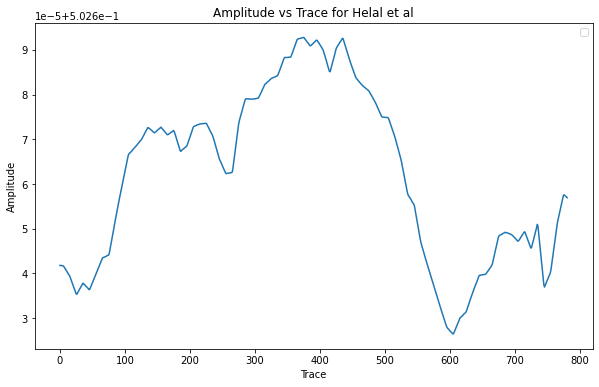

In [56]:
plt.figure(figsize=(10,6))
y_test = np_myP_1[0][0]
plt.plot(np.arange(len(y_test)), y_test)
plt.xlabel("Trace")
plt.ylabel("Amplitude")
plt.title('Amplitude vs Trace for Helal et al')
plt.legend()
plt.show()

In [37]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

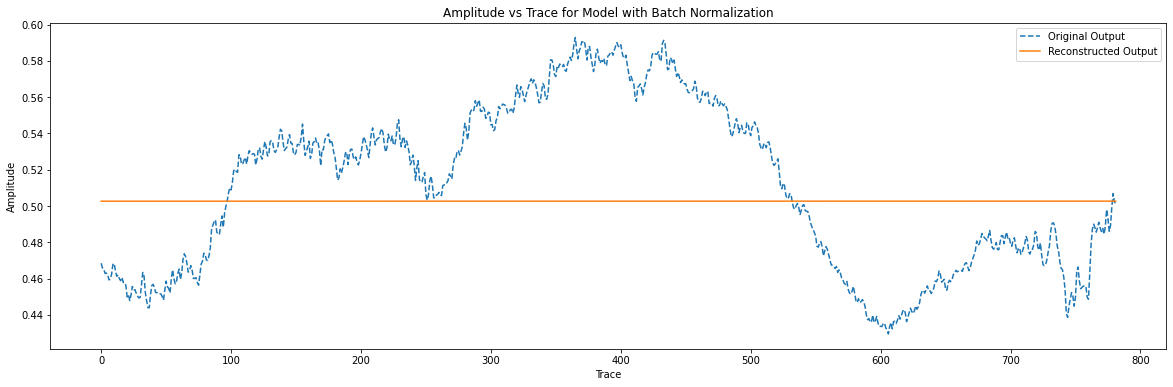

In [38]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(len(hey_test[0][0])), hey_test[0][0], '--', label='Original Output')
# norm = normalize(y_test,{'actual': {'lower': min(y_test), 'upper': max(y_test)}, 'desired': {'lower': min(hey_test[0][0]), 'upper': max(hey_test[0][0])}})
plt.plot(np.arange(len(y_test)), y_test, label='Reconstructed Output')
plt.xlabel("Trace")
plt.ylabel("Amplitude")
plt.title('Amplitude vs Trace for Model with Batch Normalization')
plt.legend()
plt.show()

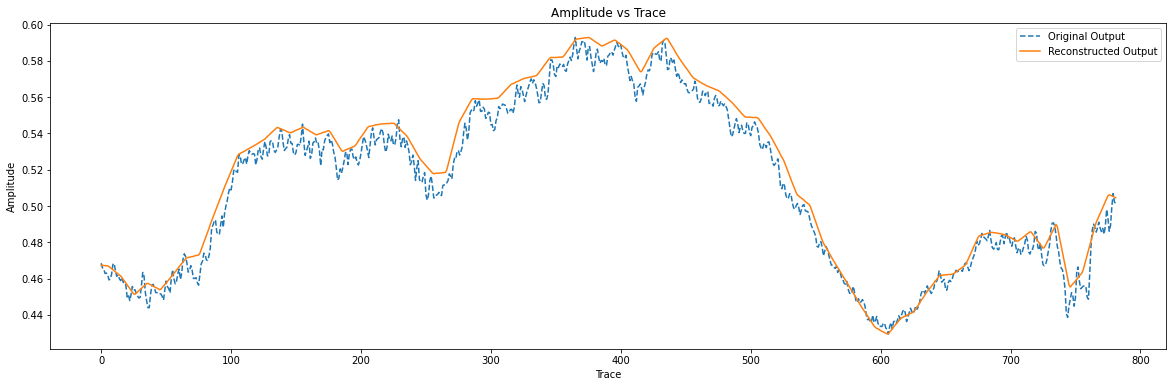

In [58]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(len(hey_test[0][0])), hey_test[0][0], '--', label='Original Output')
norm = normalize(y_test,{'actual': {'lower': min(y_test), 'upper': max(y_test)}, 'desired': {'lower': min(hey_test[0][0]), 'upper': max(hey_test[0][0])}})
plt.plot(np.arange(len(norm)), norm, label='Reconstructed Output')
plt.xlabel("Trace")
plt.ylabel("Amplitude")
plt.title('Amplitude vs Trace')
plt.legend()
plt.show()

In [ ]:
from torchview import draw_graph
import graphviz
# graphviz.set_jupyter_format('png')
model_graph1 = draw_graph(model, input_size=(1, 1, 800), save_graph = True, filename = 'model_graph_res_dec_add_linear')

In [ ]:
model_graph1.visual_graph

In [ ]:
!git clone --recursive https://github.com/waleedka/hiddenlayer.git
!cd hiddenlayer

# Install in dev mode
# !pip install -e .

fatal: destination path 'hiddenlayer' already exists and is not an empty directory.


In [ ]:
!pip install -U /content/gdrive/MyDrive/hiddenlayer/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./hiddenlayer
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=19773 sha256=3b709f3f35a7bd89ad5024bdfcec4455449431393e409a801c1e45bb11610793
  Stored in directory: /tmp/pip-ephem-wheel-cache-kss8wq68/wheels/92/8c/19/619ce3207c7d66cf2baba742e72894e97b6c01c8402a08e327
Successfully built hiddenlayer


In [ ]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

xis = torch.zeros(1, 1, 800).float()

graph = hl.build_graph(model, xis.cuda(), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('model_residual_dec_add_linear', format='pdf')

/usr/local/lib/python3.8/dist-packages/hiddenlayer/pytorch_builder.py:82: FutureWarning: 'torch.onnx._patch_torch._node_getitem' is deprecated in version 1.13 and will be removed in version 1.14. Please Internally use '_node_get' in symbolic_helper instead..
  params = {k: torch_node[k] for k in torch_node.attributeNames()}


In [ ]:
from torchviz import make_dot
model = ConvAutoencoder4(ResidualBlock, TransResidualBlock)
x = torch.ones(1, 1, 800)
y = model(input_test)
MyVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
MyVis.format = "pdf"
MyVis.view()

'Digraph.gv.pdf'

In [40]:
import math
import os

import cv2
import numpy as np

def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

In [41]:
psnr(hey_test_reshape, np_myP_corrected)

26.87236092303501

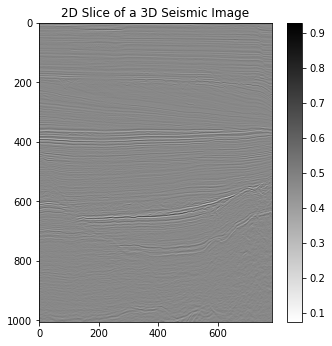

In [42]:
def plot_image(my_image):
    plt.figure(figsize=(5.5,5.5)) #dpi=300, 
    # plt.axis('off')
    plt.title("2D Slice of a 3D Seismic Image")
    plt.imshow(my_image, cmap='gray_r') #you can change the cmap to 'seismic_r' gray_r
    plt.colorbar()
plot_image(hey_test[0])

In [ ]:
plot_image(our_data[0])

NameError: ignored

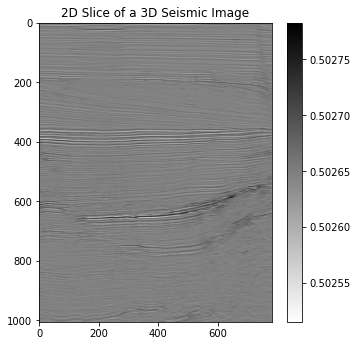

In [43]:
np_myP_corrected_reshape = np_myP_corrected.reshape(hey_test.shape)
# np_myP_norm = normalize(np_myP_corrected_reshape,{'actual': {'lower': np.min(np_myP_corrected_reshape), 'upper': np.max(np_myP_corrected_reshape)}, 'desired': {'lower': np.min(hey_test), 'upper': np.max(hey_test)}})
# np_myP_norm = np.asarray(np_myP_norm)
plot_image(np_myP_corrected_reshape[0])

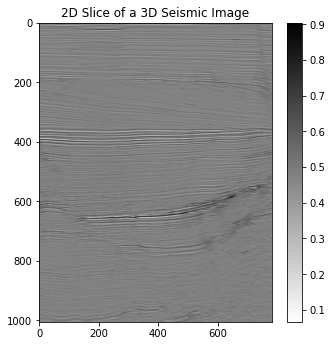

In [44]:
np_myP_corrected_reshape = np_myP_corrected.reshape(hey_test.shape)
np_myP_norm = normalize(np_myP_corrected_reshape,{'actual': {'lower': np.min(np_myP_corrected_reshape), 'upper': np.max(np_myP_corrected_reshape)}, 'desired': {'lower': np.min(hey_test), 'upper': np.max(hey_test)}})
np_myP_norm = np.asarray(np_myP_norm)
plot_image(np_myP_norm[0])

In [45]:
psnr(hey_test_reshape, np_myP_norm.reshape(np_myP_corrected.shape))

32.28969948219708

In [47]:
print(min(Train_loss))
print(min(Test_loss))

0.7296643977642471
0.7293460925557266


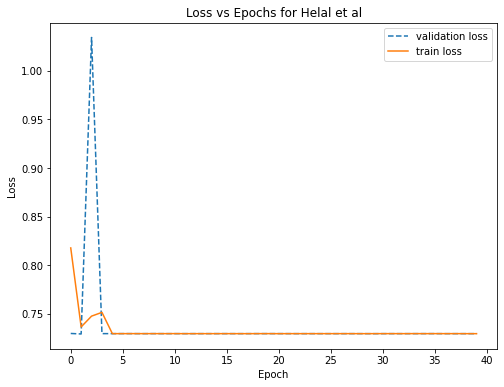

In [55]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(Test_loss)), Test_loss, '--', label='validation loss')
plt.plot(np.arange(len(Train_loss)), Train_loss, label='train loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss vs Epochs for Helal et al')
plt.legend()
plt.show()

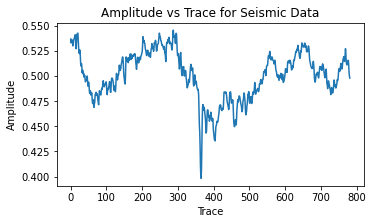

In [ ]:
plt.figure(figsize=(5.5,3))
plt.plot(np.arange(len(our_data[0][0])), our_data[0][0])
plt.xlabel("Trace")
plt.ylabel("Amplitude")
plt.title('Amplitude vs Trace for Seismic Data')
plt.show()

In [48]:
def gaussian2(size, sigma):
    """Returns a normalized circularly symmetric 2D gauss kernel array
    
    f(x,y) = A.e^{-(x^2/2*sigma^2 + y^2/2*sigma^2)} where
    
    A = 1/(2*pi*sigma^2)
    
    as define by Wolfram Mathworld 
    http://mathworld.wolfram.com/GaussianFunction.html
    """
    A = 1/(2.0*np.pi*sigma**2)
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = A*np.exp(-((x**2/(2.0*sigma**2))+(y**2/(2.0*sigma**2))))
    return g

def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()


In [49]:
def ssim(img1, img2, cs_map=False):
    """Return the Structural Similarity Map corresponding to input images img1 
    and img2 (images are assumed to be uint8)
    
    This function attempts to mimic precisely the functionality of ssim.m a 
    MATLAB provided by the author's of SSIM
    https://ece.uwaterloo.ca/~z70wang/research/ssim/ssim_index.m
    """
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    size = 11
    sigma = 1.5
    window = fspecial_gauss(size, sigma)
    K1 = 0.01
    K2 = 0.03
    L = 255 #bitdepth of image
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = signal.fftconvolve(window, img1, mode='valid')
    mu2 = signal.fftconvolve(window, img2, mode='valid')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = signal.fftconvolve(window, img1*img1, mode='valid') - mu1_sq
    sigma2_sq = signal.fftconvolve(window, img2*img2, mode='valid') - mu2_sq
    sigma12 = signal.fftconvolve(window, img1*img2, mode='valid') - mu1_mu2
    if cs_map:
        return (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)), 
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        return ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

def msssim(img1, img2):
    """This function implements Multi-Scale Structural Similarity (MSSSIM) Image 
    Quality Assessment according to Z. Wang's "Multi-scale structural similarity 
    for image quality assessment" Invited Paper, IEEE Asilomar Conference on 
    Signals, Systems and Computers, Nov. 2003 
    
    Author's MATLAB implementation:-
    http://www.cns.nyu.edu/~lcv/ssim/msssim.zip
    """
    level = 5
    weight = np.array([0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
    downsample_filter = np.ones((2, 2))/4.0
    im1 = img1.astype(np.float64)
    im2 = img2.astype(np.float64)
    mssim = np.array([])
    mcs = np.array([])
    for l in range(level):
        ssim_map, cs_map = ssim(im1, im2, cs_map=True)
        mssim = np.append(mssim, ssim_map.mean())
        mcs = np.append(mcs, cs_map.mean())
        filtered_im1 = ndimage.filters.convolve(im1, downsample_filter, 
                                                mode='reflect')
        filtered_im2 = ndimage.filters.convolve(im2, downsample_filter, 
                                                mode='reflect')
        im1 = filtered_im1[::2, ::2]
        im2 = filtered_im2[::2, ::2]
    return (np.prod(mcs[0:level-1]**weight[0:level-1])*
                    (mssim[level-1]**weight[level-1]))

In [50]:
print(msssim(hey_test_reshape, np_myP_corrected))

0.9999757136074282


In [51]:
print(msssim(hey_test_reshape, np_myP_norm.reshape(np_myP_corrected.shape)))

0.9999939206879557


In [ ]:
0.9999839936516493
0.9999559107262863

0.999984073070941
0.9999559107262863

0.9999839511992075
0.9999980010944607

0.9999839816220963
0.9999952440389264

#upsample
0.9999757136074282
0.9999939206879557

In [52]:
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())

In [53]:
nrmse(hey_test_reshape, np_myP_corrected)

0.04940444

In [54]:
nrmse(hey_test_reshape, np_myP_norm.reshape(np_myP_corrected.shape))

0.026478844

In [ ]:
0.034057546
0.020096526

0.03403558
0.023531316